In [2]:
# test
#a_0 = tf.constant([[1, 2, 1], [3,4,3]],dtype = 'float32')
#w_0 = tf.constant([[5, 6, 20, 19], [7, 8, 40, 60], [7, 8, 93, 95]],dtype = 'float32')

#with tf.Session() as sess:
#    print(tf.matmul(a_0, w_0).eval())
#    print(tf.reduce_mean(tf.matmul(a_0, w_0), 0).eval())
#    print(sess.run(tf.reduce_sum(tf.log(tf.reduce_mean(tf.matmul(a_0, w_0), 0)))))

In [3]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)

plt.style.use('ggplot')

In [4]:
def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

    return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data
ed.set_seed(42)

x_train = build_toy_dataset(N)

In [5]:
pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [6]:
T = 200  # number of MCMC samples
qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [7]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

/Users/zhonglingjiang/anaconda3/envs/mlprobprog/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


  1/200 [  0%]                                ETA: 109s | Acceptance Rate: nan
Inferred cluster means:
[[-0.15657872 -0.13609569]
 [-0.29038298 -0.13733941]]
  4/200 [  2%]                                ETA: 30s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.24641056 -0.21857803]
 [-0.13775188 -0.18136692]]
  6/200 [  3%]                                ETA: 20s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.3469376  -0.34108776]
 [-0.05208872 -0.09050049]]
  8/200 [  4%] █                              ETA: 15s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.48393294 -0.47412825]
 [ 0.0340133   0.02722355]]
 10/200 [  5%] █                              ETA: 12s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.60066754 -0.58674526]
 [ 0.2000476   0.20417415]]
 12/200 [  6%] █                              ETA: 10s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.6808888  -0.6544371 ]
 [ 0.33996984  0.34972286]]
 14/200 [  7%] ██                             E

106/200 [ 53%] ███████████████                ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.97678083 -0.93707603]
 [ 0.91806686  0.9535746 ]]
108/200 [ 54%] ████████████████               ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9775392  -0.93744147]
 [ 0.91969734  0.95494545]]
110/200 [ 55%] ████████████████               ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.978241   -0.93787056]
 [ 0.9207821   0.95593655]]
112/200 [ 56%] ████████████████               ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.97863483 -0.93818986]
 [ 0.9223252   0.95676506]]
114/200 [ 56%] █████████████████              ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.97936416 -0.93885225]
 [ 0.92355484  0.958115  ]]
116/200 [ 57%] █████████████████              ETA: 1s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.9800258  -0.9390683 ]
 [ 0.9248162   0.95920366]]
118/200 [ 59%] █████████████████              ETA: 1

In [8]:
M = 1000
mu_sample = qmu.sample(M) #(sample size, K, D)
sigmasq_sample = qsigmasq.sample(M)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))   #(T, sample size, K, D)
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, M, K, 1])  

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

In [9]:
clusters = tf.argmax(log_liks, 1).eval()

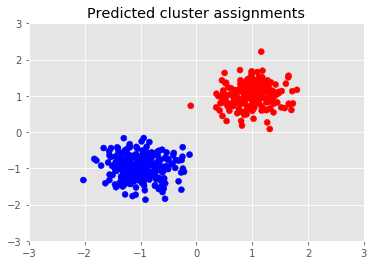

In [10]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [11]:
#M = 100
pi_sample = qpi.sample(M) # (100 * K)

In [12]:
tf.transpose(pi_sample)

<tf.Tensor 'transpose:0' shape=(2, 1000) dtype=float32>

### Posterior Dispersion Index

In [13]:
log_liks2 = x_post.log_prob(x_broadcasted) 

In [14]:
log_liks2 = tf.reduce_sum(log_liks2, 3)

In [15]:
log_liks2

<tf.Tensor 'Sum_1:0' shape=(500, 1000, 2) dtype=float32>

In [16]:
pi_samples_tiled = tf.tile(tf.expand_dims(tf.transpose(pi_sample), 0), [N, 1,1]) # [500, 7, 100], [N, K, M]

### PDI definition

In [17]:
p_x_given_theta = tf.matmul(tf.exp(log_liks2), pi_samples_tiled) #[N, ?, ?] in this case is different pi and (mu, sigma) combo
p_x_given_theta = tf.reshape(p_x_given_theta, [N, -1]) # [N, ? * ?]

In [18]:
mean, variance = tf.nn.moments(p_x_given_theta, axes=[1])

In [19]:
pdi = tf.div(variance, mean)

In [20]:
pdi_values = sess.run(pdi)

In [21]:
largest_five_pdis = pdi_values.argsort()[-5:][::-1]
pdi_values[largest_five_pdis]

array([0.532356  , 0.2271812 , 0.10206369, 0.10184751, 0.06264171],
      dtype=float32)

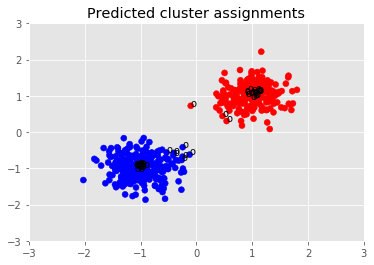

In [22]:
num_top_pdis = 50
largest_pdis = pdi_values.argsort()[-num_top_pdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_pdis): 
    plt.text(x_train[largest_pdis[i]][0],x_train[largest_pdis[i]][1] , "o", fontsize=10)
plt.show()

### WAPDI definition

In [23]:
p_x_given_theta_2 = tf.matmul(tf.exp(log_liks2), pi_samples_tiled)
p_x_given_theta_2 = tf.reshape(tf.log(p_x_given_theta), [N, -1])
mean_2, variance_2 = tf.nn.moments(p_x_given_theta_2, axes=[1])  #此处mean实现有误 原式是log mu(n)
wapdi = tf.div(variance_2, mean_2)

In [24]:
wapdi_values = sess.run(wapdi)

In [25]:
# need debugging?
largest_five_wapdis = wapdi_values.argsort()[-5:][::-1]

In [26]:
largest_five_wapdis

array([299, 171, 100, 141, 476])

In [27]:
x_train[largest_five_pdis[1]]

array([-0.12142027, -0.622538  ], dtype=float32)

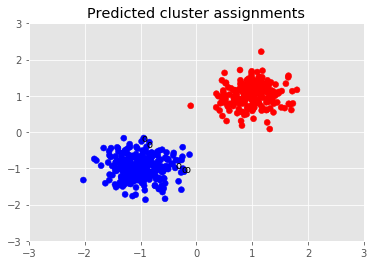

In [28]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.text(x_train[largest_five_wapdis[0]][0],x_train[largest_five_wapdis[0]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[1]][0],x_train[largest_five_wapdis[1]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[2]][0],x_train[largest_five_wapdis[2]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[3]][0],x_train[largest_five_wapdis[3]][1] , "o", fontsize=10)
plt.text(x_train[largest_five_wapdis[4]][0],x_train[largest_five_wapdis[4]][1] , "o", fontsize=10)
plt.show()

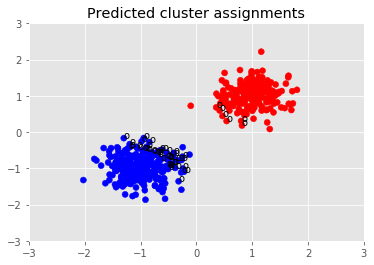

In [29]:
num_top_wapdis = 50
largest_wapdis = wapdi_values.argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=10)
plt.show()

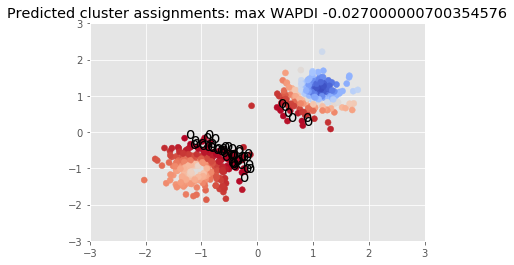

In [30]:
num_top_wapdis = 50
largest_wapdis = wapdi_values.argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=wapdi_values, cmap=plt.cm.coolwarm)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments: max WAPDI {}".format(round(wapdi_values[largest_wapdis[0]], 3)))
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=15)
    
plt.show()

In [31]:
wapdi_values[np.abs(wapdi_values).argsort()[-num_top_wapdis:][::-1]]

array([-3.702035 , -3.6921782, -3.6414015, -3.6283817, -3.6155903,
       -3.6141145, -3.5941486, -3.5858512, -3.581399 , -3.5781615,
       -3.5630763, -3.5442092, -3.5430198, -3.535005 , -3.5336578,
       -3.533251 , -3.52207  , -3.5206754, -3.517078 , -3.5132637,
       -3.506946 , -3.4875553, -3.4808066, -3.4679654, -3.44522  ,
       -3.4401317, -3.3740866, -3.3575556, -3.3381662, -3.3330805,
       -3.3265905, -3.3178935, -3.3132606, -3.287819 , -3.2749255,
       -3.2694244, -3.2576723, -3.2551885, -3.215328 , -3.2035282,
       -3.1780176, -3.1559975, -3.1403887, -3.1287816, -3.1212   ,
       -3.1181405, -3.1034641, -3.0569105, -3.030841 , -2.9898756],
      dtype=float32)

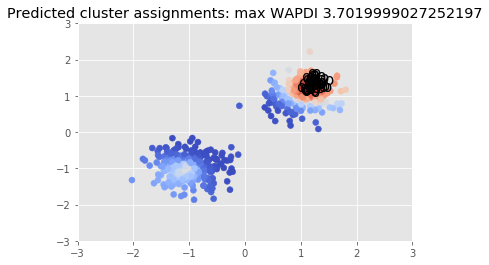

In [32]:
# we look at absolute value here
num_top_wapdis = 50
largest_wapdis = np.abs(wapdi_values).argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=np.abs(wapdi_values), cmap=plt.cm.coolwarm)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments: max WAPDI {}".format(round(np.abs(wapdi_values)[largest_wapdis[0]], 3)))
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=15)
    
plt.show()

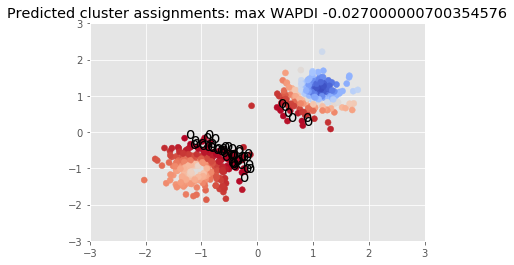

In [33]:
num_top_wapdis = 50
largest_wapdis = wapdi_values.argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=wapdi_values, cmap=plt.cm.coolwarm)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments: max WAPDI {}".format(round(wapdi_values[largest_wapdis[0]], 3)))
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=15)
    
plt.show()

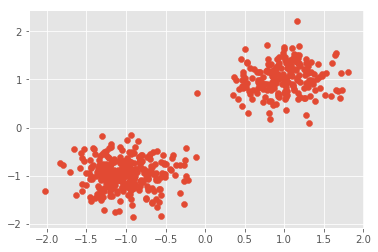

In [34]:
plt.scatter(x_train[:, 0], x_train[:, 1])

### PDI and WAPDI correction

In [35]:
log_liks3 = x_post.log_prob(x_broadcasted)

In [36]:
log_liks3 = tf.reduce_sum(log_liks3, 3)

In [37]:
pi_samples_tiled_3 = tf.tile(tf.expand_dims(pi_sample, 0), [N, 1,1]) # [500, 100, 7], [N, M, K]

In [38]:
# PDI
p_x_given_theta_3 = tf.reduce_sum(tf.multiply(pi_samples_tiled_3, tf.exp(log_liks3)), axis=2) 

In [39]:
p_x_given_theta_3

<tf.Tensor 'Sum_3:0' shape=(500, 1000) dtype=float32>

In [40]:
pdi_mean, pdi_variance = tf.nn.moments(p_x_given_theta_3, axes=[1])

In [41]:
pdi = tf.divide(pdi_variance, pdi_mean)

In [42]:
# WAPDI
_, wapdi_variance = tf.nn.moments(tf.log(p_x_given_theta_3), axes=[1])
wapdi_log_mean = tf.log(pdi_mean)
wapdi = tf.divide(wapdi_variance, wapdi_log_mean)

In [43]:
pdi_values = sess.run(pdi)
wapdi_values = sess.run(wapdi)

In [56]:
print(sess.run(tf.log(p_x_given_theta_3)))

[[-0.65094256 -0.7077737  -0.65061283 ... -1.1877857  -0.73776245
  -0.7444491 ]
 [-1.4595935  -1.7163414  -1.5145332  ... -0.92982286 -1.5390488
  -1.59569   ]
 [-0.43817005 -0.36222267 -0.37194085 ... -1.0381846  -0.54687446
  -0.44514084]
 ...
 [-1.1864022  -1.4743171  -1.3891447  ... -1.0929651  -1.5887488
  -1.517213  ]
 [-3.34188    -2.8635447  -3.1518877  ... -4.8954687  -3.1011076
  -3.133706  ]
 [-1.1918631  -1.1259582  -1.2112192  ... -5.185758   -1.0093753
  -1.2029983 ]]


In [44]:
pdi_values

array([0.0270618 , 0.01988098, 0.03560718, 0.00776226, 0.00874063,
       0.01074547, 0.03505707, 0.04376632, 0.02981185, 0.00724906,
       0.04402916, 0.01523118, 0.21623814, 0.03198617, 0.00774135,
       0.02493413, 0.02757531, 0.03554324, 0.02305801, 0.03279222,
       0.00976402, 0.01169115, 0.03442907, 0.03357219, 0.01594199,
       0.00503227, 0.01082681, 0.04570867, 0.02835795, 0.03106686,
       0.02502464, 0.0407571 , 0.01951276, 0.03619702, 0.01625979,
       0.04835601, 0.04371184, 0.04505527, 0.01150566, 0.00980214,
       0.04226587, 0.04673428, 0.04377742, 0.0168766 , 0.01334451,
       0.00634526, 0.0285237 , 0.04061487, 0.04584734, 0.02670535,
       0.04026215, 0.03489579, 0.04323674, 0.02397273, 0.04592087,
       0.03854336, 0.01054026, 0.04766754, 0.03711879, 0.03281444,
       0.02012368, 0.0212038 , 0.01895579, 0.02955425, 0.03480511,
       0.02251589, 0.03225969, 0.02093731, 0.01989111, 0.02646834,
       0.04120486, 0.01296926, 0.0275017 , 0.04323912, 0.03095

In [45]:
abs_wapdi_values = np.abs(wapdi_values)

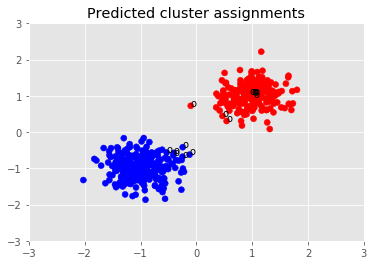

In [46]:
num_top_pdis = 15
largest_pdis = pdi_values.argsort()[-num_top_pdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_pdis): 
    plt.text(x_train[largest_pdis[i]][0],x_train[largest_pdis[i]][1] , "o", fontsize=10)
plt.show()

[0.50314647 0.21623814 0.10540844 0.10212359 0.06227997 0.05978649
 0.05721382 0.05269293 0.05204094 0.05114482 0.05108859 0.05107131
 0.05064884 0.05045696 0.04995096 0.04985794 0.04968893 0.04903798
 0.04878417 0.04865196]


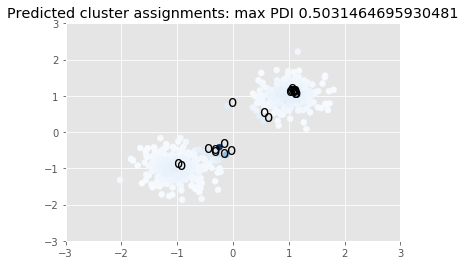

In [59]:
# we look at absolute value here
num_top_pdis = 20
largest_pdis = pdi_values.argsort()[-num_top_pdis:][::-1]
print(pdi_values[largest_pdis])
plt.scatter(x_train[:, 0], x_train[:, 1], c=pdi_values, cmap="Blues")
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments: max PDI {}".format(pdi_values[largest_pdis[0]]))
for i in range(num_top_pdis): 
    plt.text(x_train[largest_pdis[i]][0],x_train[largest_pdis[i]][1] , "o", fontsize=15)
plt.show()

In [71]:
x_train

array([[-1.3516073 , -0.89915425],
       [-0.50060904, -0.7573158 ],
       [-1.1836898 , -1.1660733 ],
       [-0.9234848 , -1.6050323 ],
       [-0.7418174 , -1.4818919 ],
       [-1.2871424 , -1.4466096 ],
       [-1.1990575 , -0.8109842 ],
       [-1.172149  , -0.9649232 ],
       [ 0.81018305,  1.2996068 ],
       [-1.1902764 , -0.4142582 ],
       [-1.1687546 , -1.0017481 ],
       [ 1.2601116 ,  0.61393535],
       [-0.12142027, -0.622538  ],
       [-0.7664764 , -0.9458086 ],
       [-1.3191009 , -1.5006816 ],
       [-1.1456667 , -0.6657086 ],
       [-1.357512  , -0.95748985],
       [ 0.78593844,  1.193429  ],
       [-0.8159166 , -0.7192693 ],
       [ 0.7346161 ,  0.90221846],
       [ 0.52308005,  1.3477389 ],
       [-1.3498539 , -1.3782737 ],
       [ 1.2639855 ,  1.093781  ],
       [-0.8856406 , -1.2040048 ],
       [ 1.4728979 ,  1.1069423 ],
       [-1.8284361 , -0.7400916 ],
       [-1.4486483 , -0.67033523],
       [-1.0694664 , -0.8870711 ],
       [-1.2495854 ,

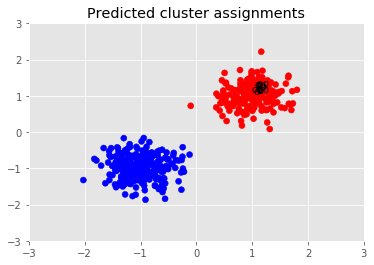

In [68]:
num_top_wapdis = 15
largest_wapdis = abs_wapdi_values.argsort()[-num_top_wapdis:][::-1]
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
for i in range(num_top_wapdis): 
    plt.text(x_train[largest_wapdis[i]][0],x_train[largest_wapdis[i]][1] , "o", fontsize=10)
plt.show()

[-4.351877  -4.341082  -4.296162  -4.2884793 -4.272426  -4.2405453
 -4.1810455 -4.1638045 -4.1041036 -4.103679  -4.0862994 -4.0737276
 -4.0010114 -3.985855  -3.9355123]


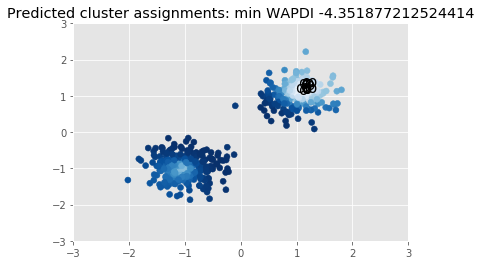

In [69]:
# we look at absolute value here
num_top_wapdis = 15
smallest_wapdis = wapdi_values.argsort()[0:num_top_wapdis]
print(wapdi_values[smallest_wapdis])
plt.scatter(x_train[:, 0], x_train[:, 1], c=wapdi_values, cmap="Blues")
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments: min WAPDI {}".format(wapdi_values[smallest_wapdis[0]]))
for i in range(num_top_wapdis): 
    plt.text(x_train[smallest_wapdis[i]][0],x_train[smallest_wapdis[i]][1] , "o", fontsize=15)
plt.show()

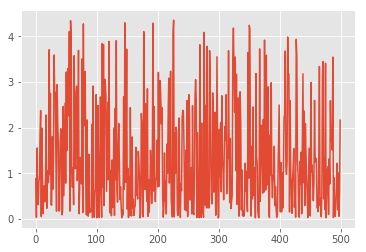

In [70]:
plt.plot(wapdi_values)

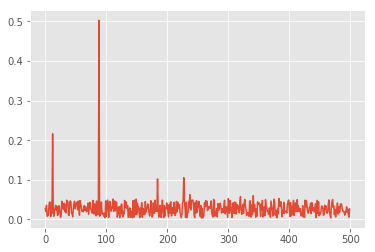

In [66]:
plt.plot(pdi_values)

In [50]:
#import tensorflow as tf

In [54]:
a_0 = tf.constant([ [[1, 1], [2, 2], [3, 3]], [[4, 4], [5, 5], [6, 6]] ], dtype='float32')
w_0 = tf.constant([ [[2,2], [3,3], [0,0]], [[2,2], [3,3], [0,0]] ],dtype = 'float32')
# x = tf.constant([[1, 220, 55], [4, 3, -1]])
# x_pseudo_max = tf.constant([[220],[4]])
# x_max = tf.expand_dims(tf.reduce_max(x, reduction_indices=[1]), axis=1)
with tf.Session() as sess2:
    print(sess2.run(tf.multiply(a_0, w_0)))
    #print(sess2.run(tf.reduce_sum(tf.multiply(a_0, w_0), axis=2)))
#     print(sess2.run(tf.add(a_0,w_0)))
#     print (sess2.run(tf.add(x, -x_max)))
#     #print(tf.reduce_mean(tf.matmul(a_0, w_0), 0).eval())
#     #print(sess.run(tf.reduce_sum(tf.log(tf.reduce_mean(tf.matmul(a_0, w_0), 0)))))

[[[ 2.  2.]
  [ 6.  6.]
  [ 0.  0.]]

 [[ 8.  8.]
  [15. 15.]
  [ 0.  0.]]]


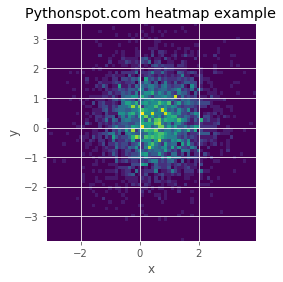

In [52]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
 
# Create data
x = np.random.randn(4096)
y = np.random.randn(4096)
 
# Create heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.title('Pythonspot.com heatmap example')
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(heatmap, extent=extent)
plt.show()